In [4]:
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a
# cosamp function is available at https://github.com/avirmaux/CoSaMP

In [3]:
def rmse(PSD1, PSD2):
    error = np.sqrt(np.mean((PSD1 - PSD2) ** 2))
    return error

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
from scipy.signal import find_peaks
sys.path.append(os.path.join('..','addDependencies','UTILS'))

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

In [ ]:
## Generate signal, DCT of signal

n = 4096 # points in high resolution signal
t = np.linspace(0,1,n)
p = 32 # num. random samples, for example, when set as 32, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
no_of_freq = 1

x = np.cos(2 * 30 * np.pi * t) 
for addfreq in range(90, 700, 60):
    
    xt = np.fft.fft(x) # Fourier transformed signal
    PSD = xt * np.conj(xt) / n # Power spectral density
    y = x[perm]
    
    Psi = dct(np.identity(n)) 
    # display(Psi)
    Theta = Psi[perm,:]       
    
    s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) 
    xrecon = idct(s)
    
    ## Plot
    time_window = np.array([0,4096])/n
    freq = np.arange(n)
    L = int(np.floor(n/2))
    
    
    fig,axs = plt.subplots(2,2)
    axs = axs.reshape(-1)
    
    axs[1].scatter(freq[:L],PSD[:L],color='k',linewidth=2)
    axs[1].set_xlim(0, 800)
    axs[1].set_ylim(0, 1200)
    
    axs[0].plot(t,x,color='k',linewidth=2)
    axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
    axs[0].set_xlim(time_window[0],time_window[1])
    axs[0].set_ylim(-2, 2)
    
    axs[2].plot(t,xrecon,color='r',linewidth=2)
    axs[2].set_xlim(time_window[0],time_window[1])
    axs[2].set_ylim(-2, 2)
    
    xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
    PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)
    
    axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
    axs[3].set_xlim(0, 800)
    axs[3].set_ylim(0, 1200)

    error = rmse(PSD[:L], PSDrecon[:L])
    fig.text(0.55, 0.47, "Error: " + f"{error.real:.5g}", fontsize=12, color='red')

    # plt.savefig("p_" + str(p) + "f_" + str(no_of_freq) + ".jpg", format='jpg', dpi=300)
    
    # plt.show()

    signal_peaks, signal_properties = find_peaks(np.real(PSD[:L]), height=1)
    recon_peaks, recon_properties = find_peaks(np.real(PSDrecon[:L]), height=1)

    signal_freq = freq[signal_peaks]
    recon_freq = freq[recon_peaks]

    signal_amp = signal_properties['peak_heights']
    recon_amp = recon_properties['peak_heights']

    # error = mse(PSD[:L], PSDrecon[:L])
    # print("Error: ", error.real)
    # print(signal_freq[signal_freq < 800])
    # print(signal_amp[signal_freq < 800])
    # print(recon_freq[recon_freq < 800])
    # print(recon_amp[recon_freq < 800])

    no_of_freq += 1
    x += np.cos(2 * addfreq * np.pi * t)

In [ ]:
def reconstruct_signal(p):
    ## Generate signal, DCT of signal

    n = 4096 # points in high resolution signal
    t = np.linspace(0,1,n)
    #p = 32 # num. random samples, for example, when set as 32, p = n/32
    perm = np.floor(np.random.rand(p) * n).astype(int)
    no_of_freq = 1
    error_per_freq = []

    x = np.cos(2 * 30 * np.pi * t) # signal

    # for regular nyquist sampling
    p_uniform = n // 2
    indices = np.linspace(0, n - 1, p_uniform, dtype=int)
    x_nyquist_samples = x[indices]
    
    for addfreq in range(90, 700, 60):
        
        # regular nyquist

        # Create a full DCT matrix
        Psi = dct(np.identity(n), norm='ortho')

        # Simulate normal sampling by selecting p DCT coefficients directly
        x_dct = dct(x_nyquist_samples, norm='ortho')
        x_recon_nyquist = idct(x_dct, norm='ortho')  # inverse DCT

        PSD_original = np.abs(np.fft.fft(x))**2 / n
        PSD_recon_nyquist = np.abs(np.fft.fft(x_recon_nyquist))**2 / n

        # sub-nyquist
        xt = np.fft.fft(x) # Fourier transformed signal
        PSD = xt * np.conj(xt) / n # Power spectral density
        y = x[perm]
        
        Psi = dct(np.identity(n)) 
        # display(Psi)
        Theta = Psi[perm,:]       
        
        s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) 
        xrecon = idct(s) 
        
        ## Plot
        # time_window = np.array([0,4096])/n
        # freq = np.arange(n)
        L = int(np.floor(n/2))
        
        
        # fig,axs = plt.subplots(2,2)
        # axs = axs.reshape(-1)
        
        # axs[1].scatter(freq[:L],PSD[:L],color='k',linewidth=2)
        # axs[1].set_xlim(0, 800)
        # axs[1].set_ylim(0, 1200)
        
        # axs[0].plot(t,x,color='k',linewidth=2)
        # axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
        # axs[0].set_xlim(time_window[0],time_window[1])
        # axs[0].set_ylim(-2, 2)
        
        # axs[2].plot(t,xrecon,color='r',linewidth=2)
        # axs[2].set_xlim(time_window[0],time_window[1])
        # axs[2].set_ylim(-2, 2)
        
        xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
        PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)
        
        # axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
        # axs[3].set_xlim(0, 800)
        # axs[3].set_ylim(0, 1200)

        error = rmse(PSD[:L], PSDrecon[:L])
        fig.text(0.55, 0.47, "Error: " + f"{error.real:.5g}", fontsize=12, color='red')
        error_per_freq.append(f"{error.real:.5g}")
        
        # plt.show()

        # plt.savefig("p_" + str(p) + "f_" + str(no_of_freq) + ".jpg", format='jpg', dpi=300)

        # signal_peaks, signal_properties = find_peaks(np.real(PSD[:L]), height=1)
        # recon_peaks, recon_properties = find_peaks(np.real(PSDrecon[:L]), height=1)

        # signal_freq = freq[signal_peaks]
        # recon_freq = freq[recon_peaks]

        # signal_amp = signal_properties['peak_heights']
        # recon_amp = recon_properties['peak_heights']

        # error = mse(PSD[:L], PSDrecon[:L])
        # print("Error: ", error.real)
        # print(signal_freq[signal_freq < 800])
        # print(signal_amp[signal_freq < 800])
        # print(recon_freq[recon_freq < 800])
        # print(recon_amp[recon_freq < 800])
        no_of_freq += 1
        x += np.cos(2 * addfreq * np.pi * t)

    return error_per_freq

In [6]:
p = 2 ** np.arange(5, 9)
error_per_p = []
frequencies = np.arange(30, 631, 60)

for i in p:
    error_per_p.append(reconstruct_signal(i))

In [12]:
frequencies = np.arange(30, 631, 60)
print(len(PSD[:L]))
print(error_per_p)
print(len(p))
print(len(error_per_p))
print(frequencies)
print(len(frequencies))
print(len(error_per_p[0]))

2048
[['0.5712', '1.5881', '72.271', '0.8836', '90.19', '157.36', '508.55', '78.3', '350.95', '197.52', '2166.9'], ['0.16741', '0.24537', '0.21987', '3.1709', '3.7117', '5.26', '13.608', '6.8565', '13.558', '11.255', '28.763'], ['0.06353', '0.62188', '1.0741', '1.473', '2.7762', '3.4127', '5.901', '8.6543', '11.636', '9.0669', '24.018'], ['0.046505', '0.28087', '0.49249', '0.65182', '0.98805', '2.6009', '3.4327', '5.2273', '6.9064', '8.2687', '24.433']]
4
4
[ 30  90 150 210 270 330 390 450 510 570 630]
11
11


In [ ]:
frequencies = np.arange(30, 631, 60)

fig1,ax1 = plt.subplots(2,2)
ax1 = ax1.reshape(-1)

# ax1[0].scatter(frequencies,error_per_p[0], label = "p = 1")
# ax1[0].legend()
# ax1[1].scatter(frequencies,error_per_p[1], label = "p = 2")
# ax1[1].legend()
# ax1[2].scatter(frequencies,error_per_p[2], label = "p = 3")
# ax1[2].legend()
# ax1[3].scatter(frequencies,error_per_p[3], label = "p = 4")
# ax1[3].legend()

for index, error in enumerate(error_per_p):
    ax1[index].scatter(frequencies,error_per_p[index], label = "p = " + str(p[index]))
    ax1[index].legend()

In [ ]:
plt.scatter(frequencies, error_per_p[0])
plt.show()

In [59]:
# Basic Nyquist Sampling

n = 4096
t = np.linspace(0, 1, n)
x = np.cos(2 * 89 * np.pi * t) + np.cos(2 * 210 * np.pi * t)  # example signal

# Nyquist-rate sampling (uniform)
p_uniform = 500
indices = np.linspace(0, n - 1, p_uniform, dtype=int)
x_nyquist_samples = x[indices]

# Create a full DCT matrix
Psi = dct(np.identity(n), norm='ortho')

# Simulate normal sampling by selecting p DCT coefficients directly
x_dct = dct(x_nyquist_samples, norm='ortho')
x_recon_nyquist = idct(x_dct, norm='ortho')  # inverse DCT

PSD_original = np.abs(np.fft.fft(x))**2 / n
PSD_recon_nyquist = np.abs(np.fft.fft(x_recon_nyquist))**2 / n

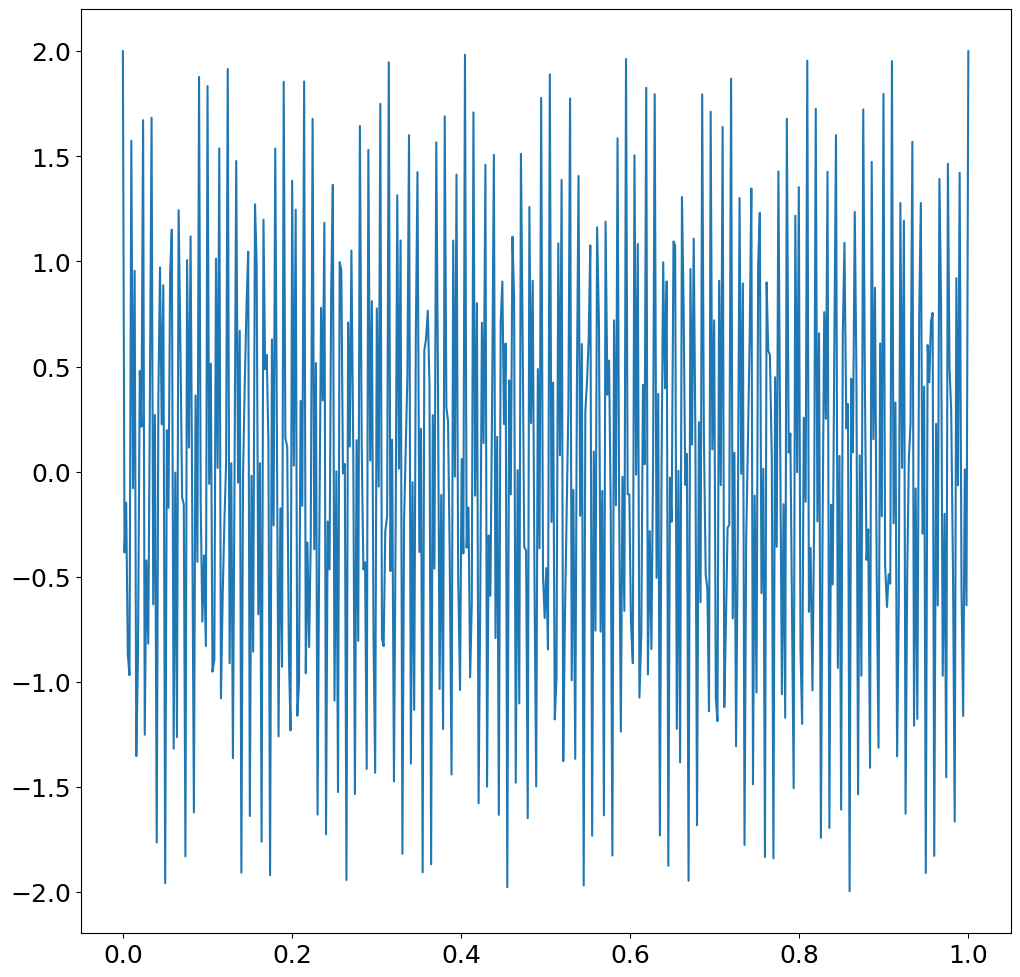

In [65]:
plt.plot(t[indices],x_recon_nyquist)

500


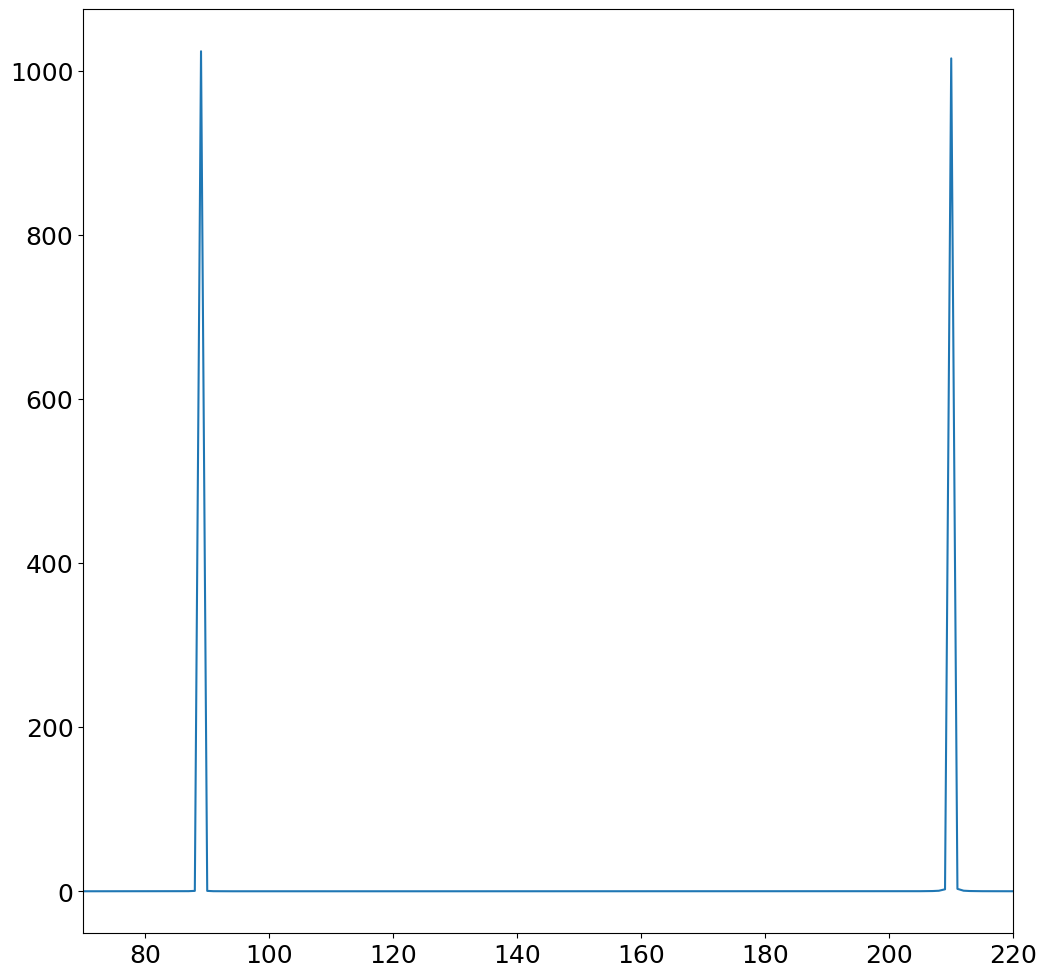

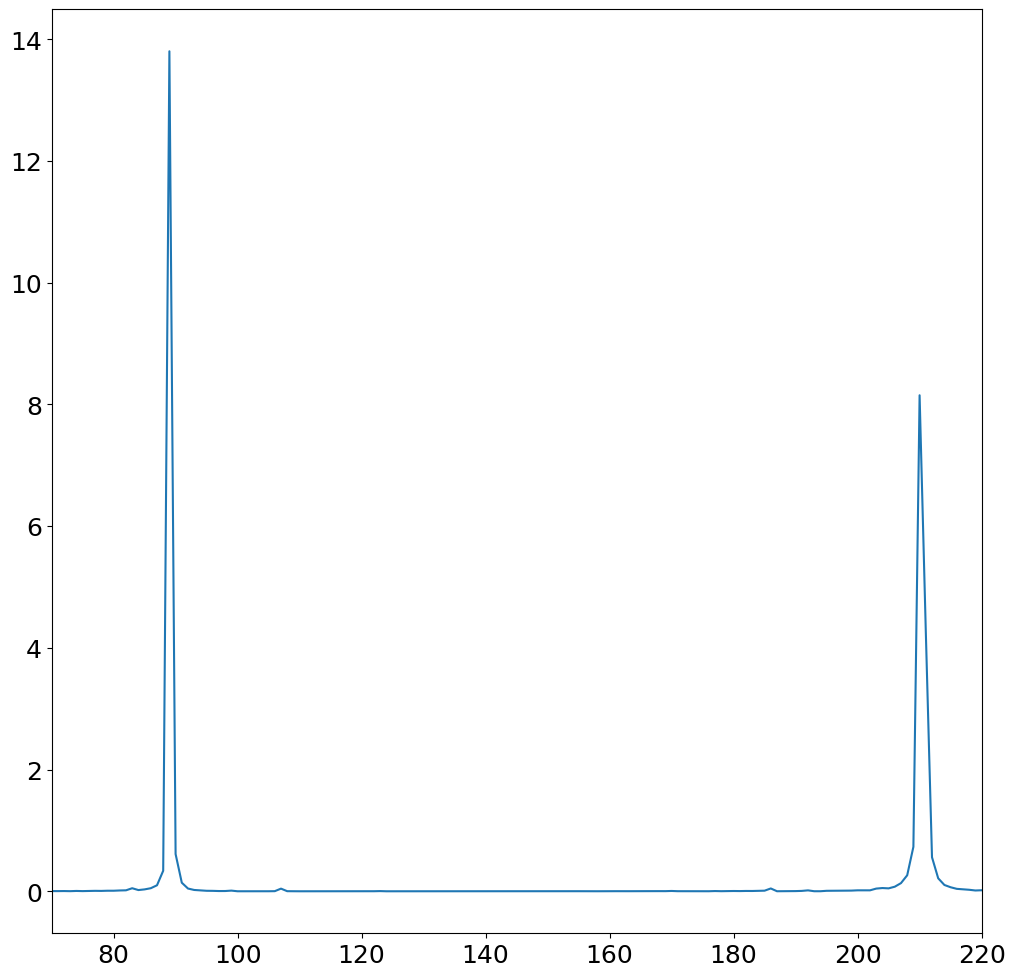

In [52]:
# print(len(PSD_original))
# print(p_uniform)
# print(indices)
print(len(indices))

plt.plot(PSD_original[:n//2])
plt.xlim(70,220)
plt.show()

# plt.plot(x)
# plt.show()

# plt.plot(x_recon_nyquist)
# plt.show()

plt.plot(PSD_recon_nyquist[:n//2])
plt.xlim(70,220)
plt.show()